<h1>Capstone 3</h1>

<h2>3. Preprocessing</h2>

**Contents**

3.1 Introduction

3.2 Creating Product Categories

    3.2.1 Cleaning & Preprocessing text data
    3.2.2 Building Bertopic Model

3.1 Preprocessing

**3.1. Indroduction**

In this notebook, I leverage an NLP model-- BERTopic to categorize products into distinct groups. Subsequently, I construct a comprehensive pipeline to preprocess the time-series data, ensuring it is well-structured and ready for integration into the forecasting model.

**3.2. Creating Product Categories**

In [196]:
#installing NLP library
!pip install bertopic

In [197]:
# Importing libraries

import numpy as np
import pandas as pd

from nltk import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer

from hdbscan import HDBSCAN
from bertopic import BERTopic
import random
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\umitk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\umitk\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [198]:
sales_df = pd.read_csv("C:/Users/umitk/OneDrive/Documents/myspringboard/Capstone_3_Demand_Forecast/Data/ForecastDataEDA.csv")
sales_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Months,DayOfMonth,DayOfWeek,WeekOfYear
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,12,1,2,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,1,2,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,12,1,2,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,1,2,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,1,2,0


**3.2.1. Cleaning & Preprocessing text data**

In [199]:
# Müşteri başına toplam miktarı hesaplayın
customer_totals = sales_df.groupby('CustomerID')['Quantity'].sum().reset_index()
customer_totals.rename(columns={'Quantity': 'CustomerPerProduct'}, inplace=True)

# Orijinal veri çerçevesine müşteri toplamlarını ekleyin
sales_df = sales_df.merge(customer_totals, on='CustomerID', how='left')


sales_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Months,DayOfMonth,DayOfWeek,WeekOfYear,CustomerPerProduct
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,12,1,2,0,1693.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,1,2,0,1693.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,12,1,2,0,1693.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,1,2,0,1693.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,1,2,0,1693.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
513672,C579886,22197,POPCORN HOLDER,-1,2011-11-30 17:39:00,0.85,15676.0,United Kingdom,11,30,2,52,2231.0
513673,C579886,23146,TRIPLE HOOK ANTIQUE IVORY ROSE,-1,2011-11-30 17:39:00,3.29,15676.0,United Kingdom,11,30,2,52,2231.0
513674,C579887,84946,ANTIQUE SILVER T-LIGHT GLASS,-1,2011-11-30 17:42:00,1.25,16717.0,United Kingdom,11,30,2,52,1568.0
513675,C579887,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,-1,2011-11-30 17:42:00,7.95,16717.0,United Kingdom,11,30,2,52,1568.0


In [200]:
sales_df['Description'].describe()

count                                 512243
unique                                  4202
top       WHITE HANGING HEART T-LIGHT HOLDER
freq                                    2306
Name: Description, dtype: object

In [201]:
#Coverting all words to lower case and removing punctuations
sales_df['Description'] = sales_df['Description'].str.lower()

sales_df['Description'] = sales_df['Description'].str.replace( '-', ' ')
sales_df['Description'] = sales_df['Description'].str.replace( ',', ' ')
sales_df['Description'] = sales_df['Description'].str.replace( '?', '')
sales_df['Description'] = sales_df['Description'].str.replace( "'", '')
sales_df['Description'] = sales_df['Description'].str.replace( ".", '')

In [202]:
#removing null values
sales_df.dropna(subset = ['Description'], inplace = True)
sales_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Months,DayOfMonth,DayOfWeek,WeekOfYear,CustomerPerProduct
0,536365,85123A,white hanging heart t light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,12,1,2,0,1693.0
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,1,2,0,1693.0
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,12,1,2,0,1693.0
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,1,2,0,1693.0
4,536365,84029E,red woolly hottie white heart,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,1,2,0,1693.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
513672,C579886,22197,popcorn holder,-1,2011-11-30 17:39:00,0.85,15676.0,United Kingdom,11,30,2,52,2231.0
513673,C579886,23146,triple hook antique ivory rose,-1,2011-11-30 17:39:00,3.29,15676.0,United Kingdom,11,30,2,52,2231.0
513674,C579887,84946,antique silver t light glass,-1,2011-11-30 17:42:00,1.25,16717.0,United Kingdom,11,30,2,52,1568.0
513675,C579887,85048,15cm christmas glass ball 20 lights,-1,2011-11-30 17:42:00,7.95,16717.0,United Kingdom,11,30,2,52,1568.0


In [203]:
products = sales_df['Description'].unique()

In [204]:
products_series = pd.Series(products)

In [205]:
#Tokenization

tokenized_list = []

for x in products:
    tokenized = word_tokenize(x)
    tokenized_list.append(tokenized)

tokenized_series = pd.Series(tokenized_list)
tokenized_series.reset_index(drop=True, inplace=True) 

print(tokenized_series)



#Stemming

porter = PorterStemmer()

def stem_words(word_list):
    return [porter.stem(word) for word in word_list]

stemmed_series = tokenized_series.apply(stem_words)

0         [white, hanging, heart, t, light, holder]
1                           [white, metal, lantern]
2              [cream, cupid, hearts, coat, hanger]
3        [knitted, union, flag, hot, water, bottle]
4               [red, woolly, hottie, white, heart]
                           ...                     
4162                   [set, of, 6, ribbons, party]
4163          [set, 10, cards, snowy, robin, 17099]
4164                              [lost, in, space]
4165    [set, 10, cards, swirly, xmas, tree, 17104]
4166                                          [wet]
Length: 4167, dtype: object


In [206]:
stemmed_df = pd.DataFrame(stemmed_series, columns = ['stemmed_words'])
stemmed_df

,stemmed_words
0,"[white, hang, heart, t, light, holder]"
1,"[white, metal, lantern]"
2,"[cream, cupid, heart, coat, hanger]"
3,"[knit, union, flag, hot, water, bottl]"
4,"[red, woolli, hotti, white, heart]"
...,...
4162,"[set, of, 6, ribbon, parti]"
4163,"[set, 10, card, snowi, robin, 17099]"
4164,"[lost, in, space]"
4165,"[set, 10, card, swirli, xma, tree, 17104]"


In [207]:
stemmed_df['products'] = products_series

Why? Tokenization breaks down text into smaller units (typically words), making it more manageable for further analysis, such as finding word stems.

Why? Stemming finds the root forms of words, which reduces different inflections of words (e.g., "running," "ran," "runs") to the same root form (e.g., "run"). This helps create a more uniform text structure and preserves meanings, making it particularly useful in text mining, search engines, and information retrieval systems.

In [208]:
#manually creating category names for the products

category_names = ['Home and living', 'Kitchen and Dining', 'Toys', 
                  'Clothing and Accessories', 'Seasonal and Decorative', 'Miscellaneous'] 
category_names_seies = pd.DataFrame(category_names, columns = ['Category'])

categories = category_names_seies.index.to_list()

In [209]:
manual_assigned_df = stemmed_df.iloc[:50]
remaining_descriptions = stemmed_df.iloc[50:]

Splitting the Data: This operation allows you to divide a large dataset into smaller parts, making it easier to perform separate operations on each part. For example, if you want to manually process the first 50 rows, you can separate them into a different DataFrame for easy access.

Manual Operations: The manual_assigned_df can be used for data on which you want to manually assign categories, make adjustments, or conduct detailed reviews.

Storing Remaining Data: The remaining_descriptions holds the data that hasn’t been processed yet or that will be processed differently. This helps you manage operations in an organized and sequential manner.

In [210]:
#manually assigning the first 50 products to the categories created

manual_categories = [0, 0, 3, 3, 3, 4, 0, 3, 3, 4, 2, 2, 2, 1, 1, 2, 2, 
                     0, 0, 0, 0, 1, 3, 3, 3, 0, 0, 0, 0, 4, 4, 5, 2, 1, 
                     1, 1, 1, 1, 3, 0, 1, 2, 2, 2, 2, 4, 3, 1, 1, 1]

In [211]:
manual_assigned_df['categories'] = manual_categories
remaining_descriptions['categories'] = -1

In [212]:
#putting data in the right format

manual_assigned_df['stemmed_words'] = manual_assigned_df['stemmed_words'].apply(lambda x: ' '.join(x))
remaining_descriptions['stemmed_words'] = remaining_descriptions['stemmed_words'].apply(lambda x: ' '.join(x))

In [213]:
products_df = pd.concat([manual_assigned_df,remaining_descriptions])

In [214]:
products_df

,stemmed_words,products,categories
0,white hang heart t light holder,white hanging heart t light holder,0
1,white metal lantern,white metal lantern,0
2,cream cupid heart coat hanger,cream cupid hearts coat hanger,3
3,knit union flag hot water bottl,knitted union flag hot water bottle,3
4,red woolli hotti white heart,red woolly hottie white heart,3
...,...,...,...
4162,set of 6 ribbon parti,set of 6 ribbons party,-1
4163,set 10 card snowi robin 17099,set 10 cards snowy robin 17099,-1
4164,lost in space,lost in space,-1
4165,set 10 card swirli xma tree 17104,set 10 cards swirly xmas tree 17104,-1


In [215]:
pdcts = products_df['stemmed_words'].astype(str)
pdcts = tuple(pdcts)

y = products_df['categories']
y = tuple(y)

Why Did We Do This?

Data Integrity: Tuples are immutable, ensuring that the data remains unchanged during processing and analysis.
Machine Learning and Analysis: Tuples are a standard format for storing data that will be used for modeling, helping maintain consistency and integrity.

Maintaining Data Structure: Using tuples helps keep the data organized in a specific order, which is useful for analysis and comparisons.
These steps help to format the data in a stable, unchangeable form, making it suitable for analysis and modeling.

**3.2.2. Building the Model**

**Model**

In [216]:
random.seed(0)



hdbscan_model = HDBSCAN(min_cluster_size=50, metric='euclidean', min_samples=10,
                        cluster_selection_method='eom', prediction_data=True)


topic_model = BERTopic(hdbscan_model=hdbscan_model, nr_topics= 15, n_gram_range=(1, 2), verbose =  True)
topics, _ = topic_model.fit_transform(pdcts, y=y)

2024-08-28 12:20:16,293 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/131 [00:00<?, ?it/s]

2024-08-28 12:21:14,756 - BERTopic - Embedding - Completed ✓
2024-08-28 12:21:14,756 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-08-28 12:21:37,757 - BERTopic - Dimensionality - Completed ✓
2024-08-28 12:21:37,773 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-08-28 12:21:38,195 - BERTopic - Cluster - Completed ✓
2024-08-28 12:21:38,195 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-08-28 12:21:38,398 - BERTopic - Representation - Completed ✓
2024-08-28 12:21:38,398 - BERTopic - Topic reduction - Reducing number of topics
2024-08-28 12:21:38,804 - BERTopic - Topic reduction - Reduced number of topics from 27 to 15


In [217]:
topic_model.get_topic_freq()

,Topic,Count
2,0,1410
1,-1,1250
0,1,287
13,2,264
8,3,258
3,4,99
10,5,92
4,6,86
11,7,70
6,8,61


In [218]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1250,-1_blue_pink_paper_flower,"[blue, pink, paper, flower, card, clock, ring,...","[letter `` o '' bling key ring, letter `` i ''..."
1,0,1410,0_bag_heart_set_decor,"[bag, heart, set, decor, of, pink, set of, red...","[jumbo bag pink vintag paisley, larg cake stan..."
2,1,287,1_holder_candl_light_light holder,"[holder, candl, light, light holder, zinc, pot...","[zinc star t light holder, heart t light holde..."
3,2,264,2_necklac_ear_bracelet_drop,"[necklac, ear, bracelet, drop, black, bead, cr...","[glass bead hoop ear black, glass bead hoop ne..."
4,3,258,3_set 10_10_10 card_card,"[set 10, 10, 10 card, card, tissu, set, of 12,...","[set 10 card christma stamp 16963, set 10 card..."
5,4,99,4_girl_dolli girl_dolli_mini,"[girl, dolli girl, dolli, mini, spaceboy, chil...","[dolli girl mini backpack, mini jigsaw dolli g..."
6,5,92,5_mirror_magnet_mirror wall_wall,"[mirror, magnet, mirror wall, wall, fridg, fri...","[set/4 daisi mirror magnet, set/4 bird mirror ..."
7,6,86,6_vintag_tin vintag_tin_vintag red,"[vintag, tin vintag, tin, vintag red, biscuit ...","[biscuit tin vintag christma, biscuit tin vint..."
8,7,70,7_cover_cushion_cushion cover_food cover,"[cover, cushion, cushion cover, food cover, fo...","[pink butterfli cushion cover, pink butterfli ..."
9,8,61,8_frame_photo_photo frame_jewel,"[frame, photo, photo frame, jewel, pictur fram...","[photo frame cornic, pink jewel photo frame, p..."


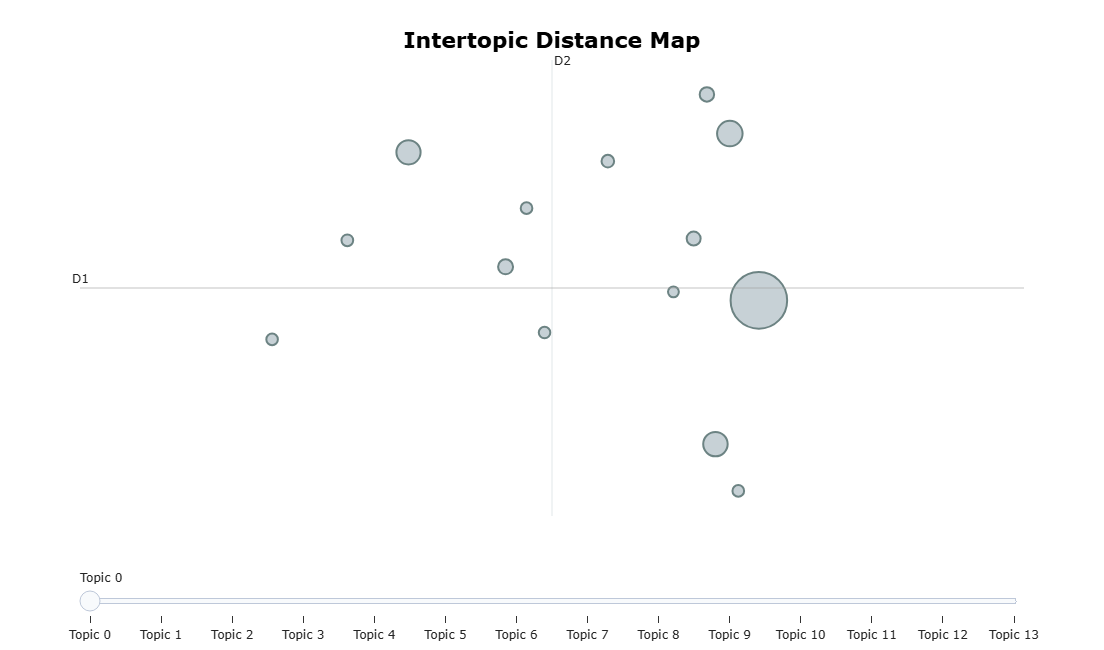

In [219]:
topic_model.visualize_topics() 

In [220]:
# Saving the model
topic_model.save("category_model")

2024-08-28 12:21:41,371 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


<h2>Preprocessing</h2>

In [221]:
# Loading the category model
my_model = BERTopic.load("category_model")

In [222]:
products_list = products_df.drop('categories', axis = 1)
products_list = products_df.drop('stemmed_words', axis = 1)

In [223]:
products_list['Category'] = topics

In [224]:
products_list.drop(columns = 'categories', axis = 1)

,products,Category
0,white hanging heart t light holder,1
1,white metal lantern,-1
2,cream cupid hearts coat hanger,0
3,knitted union flag hot water bottle,-1
4,red woolly hottie white heart,0
...,...,...
4162,set of 6 ribbons party,-1
4163,set 10 cards snowy robin 17099,3
4164,lost in space,4
4165,set 10 cards swirly xmas tree 17104,3


In [225]:
merged_df = pd.merge(sales_df, products_list, left_on='Description', right_on='products', how='left')

In [226]:
merged_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Months,DayOfMonth,DayOfWeek,WeekOfYear,CustomerPerProduct,products,categories,Category
0,536365,85123A,white hanging heart t light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,12,1,2,0,1693.0,white hanging heart t light holder,0,1
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,1,2,0,1693.0,white metal lantern,0,-1
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,12,1,2,0,1693.0,cream cupid hearts coat hanger,3,0
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,1,2,0,1693.0,knitted union flag hot water bottle,3,-1
4,536365,84029E,red woolly hottie white heart,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,1,2,0,1693.0,red woolly hottie white heart,3,0


In [227]:
#Building preprocessing pipeline

class RemoveNegatives(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
                  
    def transform(self, X):
        X = X[X['Quantity'] >0]
        return X

class CreateFeature(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
                  
    def transform(self, X):
        n = pd.DataFrame(X.groupby('Category')['CustomerPerProduct'].sum())
        n = n.reset_index()
        n.rename(columns = {'CustomerPerProduct': 'CustomerPerCategory'}, inplace = True)
        X = X.merge(n, how='left', left_on='Category', right_on='Category')
        return X   
    
class ProcessDates(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
                  
    def transform(self, X):
        if 'InvoiceDate' in X.columns:
            X['InvoiceDate'] = pd.to_datetime(X['InvoiceDate'])
            start_date =  pd.to_datetime('2011-01-04 08:00:00')
            X['WeekOfYear'] = (((X['InvoiceDate'] - start_date).dt.days)/7).astype(int)
            X['WeekStartDate'] = X['InvoiceDate'] - pd.to_timedelta(X['InvoiceDate'].dt.dayofweek, unit='D')
            X['WeekStartDate'] = X['WeekStartDate'].dt.date
            X = X[X['WeekOfYear'] >0]
        else:
            print("Error: 'InvoiceDate' column not found in DataFrame.")
        return X

    
class Grouping(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
                  
    def transform(self, X):
        X = X.groupby(['WeekStartDate', 'Category', 'CustomerPerCategory' ])['Quantity'].sum()
        X = pd.DataFrame(X)
        X = X.reset_index()
        X = X.set_index('WeekStartDate')
        return X

In [228]:
pipeline = Pipeline([
    ('remove', RemoveNegatives()),
    ('features', CreateFeature()),
    ('dates', ProcessDates()),
    ('group', Grouping())
])


In [232]:
preprocessed_data = pipeline.fit_transform(merged_df)

In [233]:
preprocessed_data

,Category,CustomerPerCategory,Quantity
WeekStartDate,,,
2011-01-10,-1,6.944016e+08,16931
2011-01-10,0,1.048645e+09,38008
2011-01-10,1,1.209392e+08,8062
2011-01-10,2,6.718824e+06,96
2011-01-10,3,4.923072e+07,2473
...,...,...,...
2011-11-28,9,6.946356e+07,3786
2011-11-28,10,4.389032e+07,2865
2011-11-28,11,2.473839e+07,1861


In [235]:
preprocessed_data.to_csv('C:/Users/umitk/OneDrive/Documents/myspringboard/Capstone_3_Demand_Forecast/Data/preprocessed_forecast_data.csv')

In [236]:
split =int(len(preprocessed_data) * 0.8) 

train, test = preprocessed_data[0:split] , preprocessed_data[split:len(preprocessed_data)]

In [237]:
train.to_csv('C:/Users/umitk/OneDrive/Documents/myspringboard/Capstone_3_Demand_Forecast/Data/train_forecast.csv')
test.to_csv('C:/Users/umitk/OneDrive/Documents/myspringboard/Capstone_3_Demand_Forecast/Data/test_forecast.csv')